# Imports

In [15]:
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
%matplotlib inline
from os import listdir
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Uncomment if using Google Colab

In [16]:
# from google.colab import drive
# mount_path = '/content/gdrive/'
# drive.mount(mount_path)

In [17]:
# data_path = 'My Drive/project2'
# data_dir = mount_path + data_path
# print(data_dir)

# Data Handling

**Build dataframes**

Build image dataframes and one hot encoded labels from previously obtained pickled files

In [18]:
X = pd.read_pickle('X1.pkl')
y = pd.read_pickle('y1.pkl')
for i in range(1,13):
    tmp_X = pd.read_pickle(f'X{i+1}.pkl')
    tmp_y = pd.read_pickle(f'y{i+1}.pkl')
    X = np.concatenate((X, tmp_X), axis=0)
    y = y.append(tmp_y, ignore_index=True)

In [19]:
X.shape

(12973,)

In [20]:
X = np.stack(X, axis=0) #Join X along a new axis
print('X shape', X.shape, '\ny shape', y.shape)  #Ensure shapes are correct

X shape (12973, 224, 224, 3) 
y shape (12973, 10)


Split to train and test. Tensorflow would add an additional split for validation set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42)


In [22]:
X_train.shape #Ensure shapes are correct

(10378, 224, 224, 3)

In [58]:
y.describe()

,keyword_animal,keyword_human,keyword_mountain,keyword_nature,keyword_outdoors,keyword_person,keyword_plant,keyword_sea,keyword_tree,keyword_water
count,12973.000000,12973.000000,12973.000000,12973.000000,12973.000000,12973.000000,12973.000000,12973.000000,12973.000000,12973.000000
mean,0.120327,0.081014,0.096662,0.527788,0.478995,0.081014,0.302783,0.073614,0.093733,0.137439
std,0.325356,0.272868,0.295509,0.499246,0.499578,0.272868,0.459480,0.261152,0.291468,0.344324
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model

**Building the model**

**1. Inception with max pool**

In [59]:
inception_model = InceptionV3(include_top=False, input_shape=(224, 224, 3), weights='imagenet') # remove the outermost layer to allow multilabel classification, define input shape size

In [60]:
inception_model.trainable = False #Freeze the inception model

**2. Sequential model**

Build a multilabel model on top of Inception

In [61]:
max_model = Sequential(
    [inception_model,
     Flatten(),
     #GlobalAveragePooling2D(),
     Dense(128, activation='relu'),
     Dense(10, activation='sigmoid')]
)

In [62]:
max_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 28,357,802
Trainable params: 6,555,018
Non-trainable params: 21,802,784
_________________________________________________________________


Compile the model: 
1. Binary crossnentropy used for multilabel classification
2. Following the validation accuracy to avoid overfit of the model.
3. Stopping the training phase if the model's validation loss doesn't improve after 3 iterations.

In [63]:

max_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
max_model_checkpoint_callback = ModelCheckpoint(
                            filepath = './',
                            save_weights_only = False,
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True)
earlystop = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

# Train

**Train the model**

In [64]:
max_pool_history = max_model.fit(X_train, y_train,
                    epochs = 15,
                    batch_size = 64,
                    validation_split = 0.1,
                    callbacks=[max_model_checkpoint_callback, earlystop])

Train on 9340 samples, validate on 1038 samples
Epoch 1/15
9340/9340 [==============================] - 1578s 169ms/sample - loss: 0.5427 - accuracy: 0.8626 - val_loss: 12.9364 - val_accuracy: 0.8086
Epoch 2/15
9340/9340 [==============================] - 1702s 182ms/sample - loss: 0.2351 - accuracy: 0.9079 - val_loss: 17.9080 - val_accuracy: 0.7958
Epoch 3/15
9340/9340 [==============================] - 2114s 226ms/sample - loss: 0.1949 - accuracy: 0.9227 - val_loss: 17.5915 - val_accuracy: 0.8084
Epoch 4/15
9340/9340 [==============================] - 1819s 195ms/sample - loss: 0.1628 - accuracy: 0.9355 - val_loss: 22.3669 - val_accuracy: 0.8073
Epoch 00004: early stopping


In [65]:
def plot_loss_over_epoches(history):
    """This function plots loss and accuracy values of the training history as a function of epoch number"""
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.plot(history.history['accuracy'], color='salmon', label="Training accuracy")
    ax.plot(history.history['val_accuracy'], color='purple', label="validation accuracy")
    ax.set_title("Accuracy over epoches")
    ax.grid(alpha=0.2)
    legend = ax.legend(loc='best', shadow=True)

    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.plot(history.history['loss'], color='salmon', label="Training loss")
    ax.plot(history.history['val_loss'], color='purple', label="validation loss")
    ax.set_title("Loss over epoches")
    ax.grid(alpha=0.2)
    legend = ax.legend(loc='best', shadow=True)

    plt.tight_layout()
    plt.show()

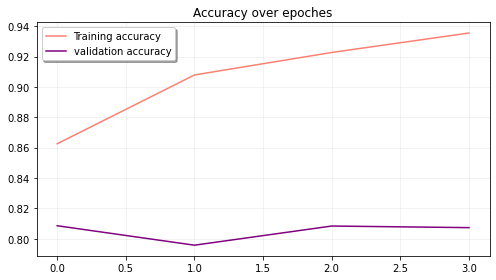

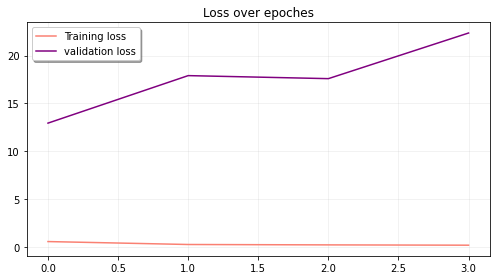

In [66]:
plot_loss_over_epoches(max_pool_history)

# Prediction

**Prediction and Visualisation**

In [75]:
y.head()

,keyword_animal,keyword_human,keyword_mountain,keyword_nature,keyword_outdoors,keyword_person,keyword_plant,keyword_sea,keyword_tree,keyword_water
0,0,0,0,0,0,0,1,0,1,0
1,0,1,0,0,0,1,0,0,0,0
2,0,0,1,1,1,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0


**max**

In [67]:
y_pred_max = max_model.predict(X_test)

In [77]:
y_preds = pd.DataFrame(y_pred_max)
y_pred_max[:,5]!=0

array([ True, False,  True, ..., False, False, False])

In [68]:
col_dict = dict(zip(np.arange(10), y.columns))
col_dict

{0: 'keyword_animal',
 1: 'keyword_human',
 2: 'keyword_mountain',
 3: 'keyword_nature',
 4: 'keyword_outdoors',
 5: 'keyword_person',
 6: 'keyword_plant',
 7: 'keyword_sea',
 8: 'keyword_tree',
 9: 'keyword_water'}

In [69]:
def pic(X, y_pred, col_dict): 
    print('-------------------------------------------')
    for i in range(10):
      confidence = (round(y_pred[i], 4) * 100)
      if confidence > 20:
        print(f'{col_dict[i]} - {confidence}%')
    plt.figure(figsize=(6,6))
    plt.imshow(X)
    plt.axis('off')
    plt.show()
    print('-------------------------------------------', end='\n\n\n')

-------------------------------------------
keyword_nature - 100.0%


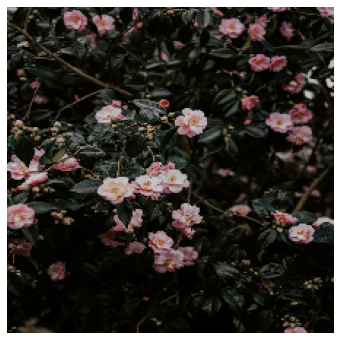

-------------------------------------------


-------------------------------------------
keyword_nature - 100.0%


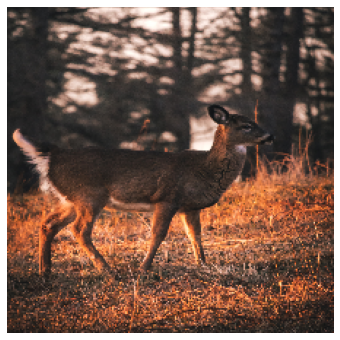

-------------------------------------------


-------------------------------------------
keyword_nature - 100.0%


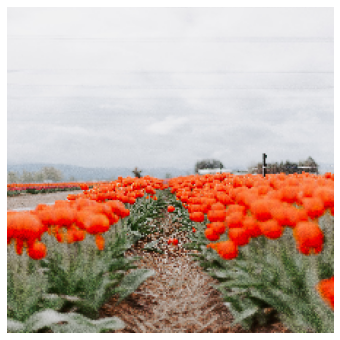

-------------------------------------------


-------------------------------------------
keyword_nature - 100.0%


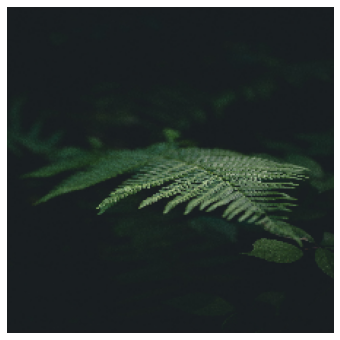

-------------------------------------------


-------------------------------------------
keyword_nature - 100.0%
keyword_outdoors - 100.0%


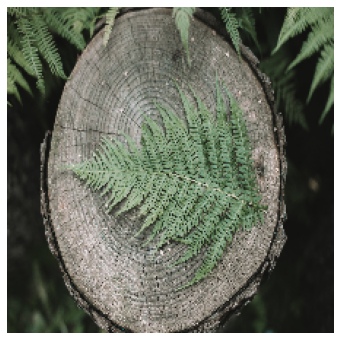

-------------------------------------------


-------------------------------------------
keyword_nature - 100.0%


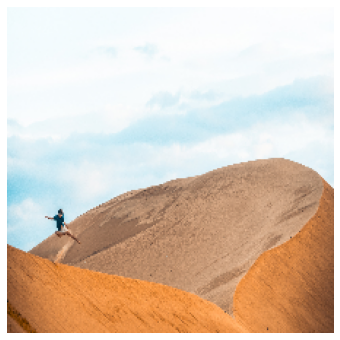

-------------------------------------------


-------------------------------------------


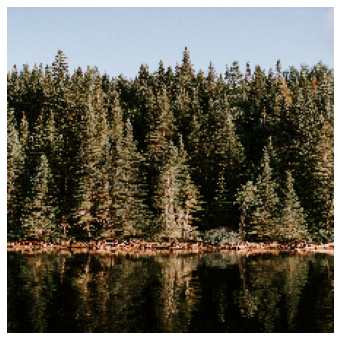

-------------------------------------------


-------------------------------------------
keyword_nature - 99.98000264167786%


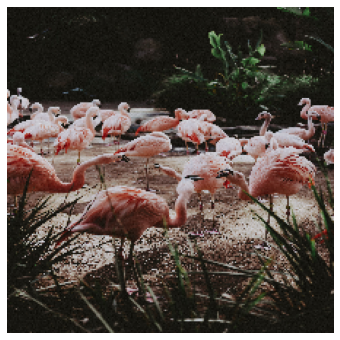

-------------------------------------------




In [70]:
for row in range(10,40, 4):
    pic(X_test[row], y_pred_max[row], col_dict)

In [71]:
# save model and architecture to single file
max_model.save("max_inception_model.h5")
print("Saved model to disk")

Saved model to disk


In [78]:
max_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 28,357,802
Trainable params: 6,555,018
Non-trainable params: 21,802,784
_________________________________________________________________


# Future tweaks

Data Augmentation - not used because it was very heavy on the RAM

In [ ]:
# datagen = ImageDataGenerator( 
#                             rotation_range = 90,
#                             horizontal_flip=True,
#                             vertical_flip = True
#                             )

# train_gen = datagen.flow(X_train, y_train)

In [ ]:
#Unfreeze the inception model and have another round of training
for layer in inception_model.layers[-15:]:
    layer.trainable = True

In [ ]:
opt = Adam(learning_rate=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs = 15,
                    batch_size = 64,
                    validation_split = 0.1,
                    callbacks=[model_checkpoint_callback, earlystop])